In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt



In [50]:
file_path = './data/diabetes.csv'
diabetes_df = pd.read_csv(file_path)


In [51]:
X = diabetes_df.iloc[:, :-1].to_numpy() 
y = diabetes_df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Perceptron

In [52]:

class Perceptron(ABC):
    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def activation_function(self, x):
        pass


# RosenBaltt Perceptron - Baseline

In [53]:
class RosenblattPerceptron(Perceptron):
    def __init__(self, learning_rate=0.001, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.w = None

    # Activation function: step function
    def activation_function(self, x):
        return np.where(x >= 0, 1, -1)

    def fit(self, X, y):
        n_samples, m_features = X.shape
        self.w = np.zeros(m_features + 1)  # Initialize weights and bias to zero

        for _ in range(self.max_iter):
            for i in range(n_samples):
                # Linear combination of inputs and weights, Y = XW + b
                output = X[i] @ self.w[1:] + self.w[0]
                y_pred = self.activation_function(output)
                error = y[i] - y_pred

                # Update the weights and bias
                delta_w = self.learning_rate * error
                self.w[1:] += delta_w * X[i]
                self.w[0] += delta_w

    def predict(self, X):
        output = X @ self.w[1:] + self.w[0]
        return self.activation_function(output)


# Sigmoid Perceptron

In [54]:
class SigmoidPerceptron(RosenblattPerceptron):
    def __init__(self, learning_rate=0.001, max_iter=1000):
        super().__init__(learning_rate, max_iter)

    # Sigmoid activation function
    def activation_function(self, x):
        x = np.clip(x, -500, 500) 
        return 2 / (1 + np.exp(-x)) - 1

    def predict(self, X):
        output = X @ self.w[1:] + self.w[0]
        y_pred = self.activation_function(output)
        return np.where(y_pred >= 0, 1, -1)


# Tanh Perceptron

In [55]:

class TanhPerceptron(RosenblattPerceptron):
    def __init__(self, learning_rate=0.001, max_iter=1000):
        super().__init__(learning_rate, max_iter)

    def activation_function(self, x):
        return np.tanh(x)
    
    def predict(self, X):
        output = X @ self.w[1:] + self.w[0]
        y_pred = self.activation_function(output)
        return np.where(y_pred >= 0, 1, -1)


# Train and evaluate the models

In [56]:

models = {
    'Rosenblatt Perceptron': RosenblattPerceptron(),
    'Sigmoid Perceptron': SigmoidPerceptron(),
    'Tanh Perceptron': TanhPerceptron(),
    'SVM': SVC()
}

results = []

# Loop through each model, train on the 80-20 split, and evaluate accuracy, precision, recall, F1-score
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_split = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred_split)
    precision = precision_score(y_test, y_pred_split)
    recall = recall_score(y_test, y_pred_split)
    f1 = f1_score(y_test, y_pred_split)
    
    # Append results to list
    results.append([model_name, accuracy, precision, recall, f1])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

results_df




,Model,Accuracy,Precision,Recall,F1-Score
0,Rosenblatt Perceptron,0.759740,0.762712,0.909091,0.829493
1,Sigmoid Perceptron,0.746753,0.812500,0.787879,0.800000
2,Tanh Perceptron,0.753247,0.814433,0.797980,0.806122
3,SVM,0.733766,0.773585,0.828283,0.800000


# Plot the graphs

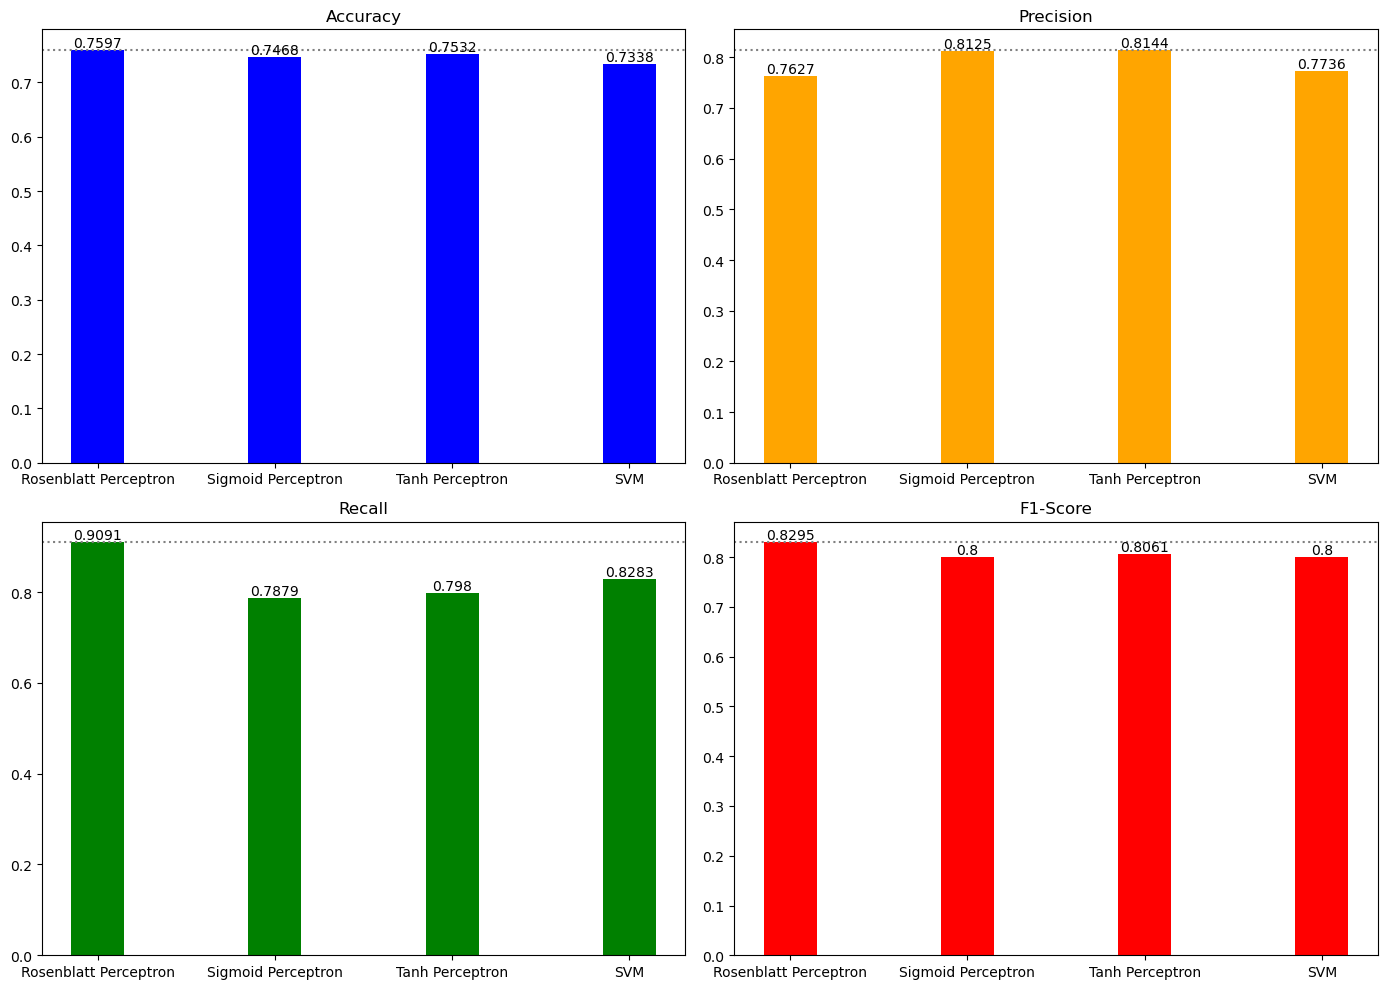

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
bar_width = 0.3

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'orange', 'green', 'red']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    bars = ax[row, col].bar(results_df['Model'], results_df[metric], color=colors[i], width=bar_width)
    ax[row, col].set_title(metric)
    
    max_val = max([bar.get_height() for bar in bars])
    ax[row, col].axhline(y=max_val, color='gray', linestyle='dotted', linewidth=1.5)
    
    for bar in bars:
        yval = bar.get_height()
        ax[row, col].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va='bottom', ha='center')

plt.tight_layout()
plt.show()


# Cross Validation

In [58]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_test_cv = scaler.transform(X_test_cv)

    rb_perceptron = RosenblattPerceptron()
    rb_perceptron.fit(X_train_cv, y_train_cv)
    
    y_pred_cv = rb_perceptron.predict(X_test_cv)
    
    accuracy_list.append(accuracy_score(y_test_cv, y_pred_cv))
    precision_list.append(precision_score(y_test_cv, y_pred_cv))
    recall_list.append(recall_score(y_test_cv, y_pred_cv))
    f1_score_list.append(f1_score(y_test_cv, y_pred_cv))

results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_score_list
})

results_df


,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.675325,0.737864,0.767677,0.752475
1,2,0.655844,0.800000,0.672897,0.730964
2,3,0.655844,0.738095,0.666667,0.700565
3,4,0.797386,0.815126,0.915094,0.862222
4,5,0.745098,0.785714,0.810526,0.797927


# Plot the graphs

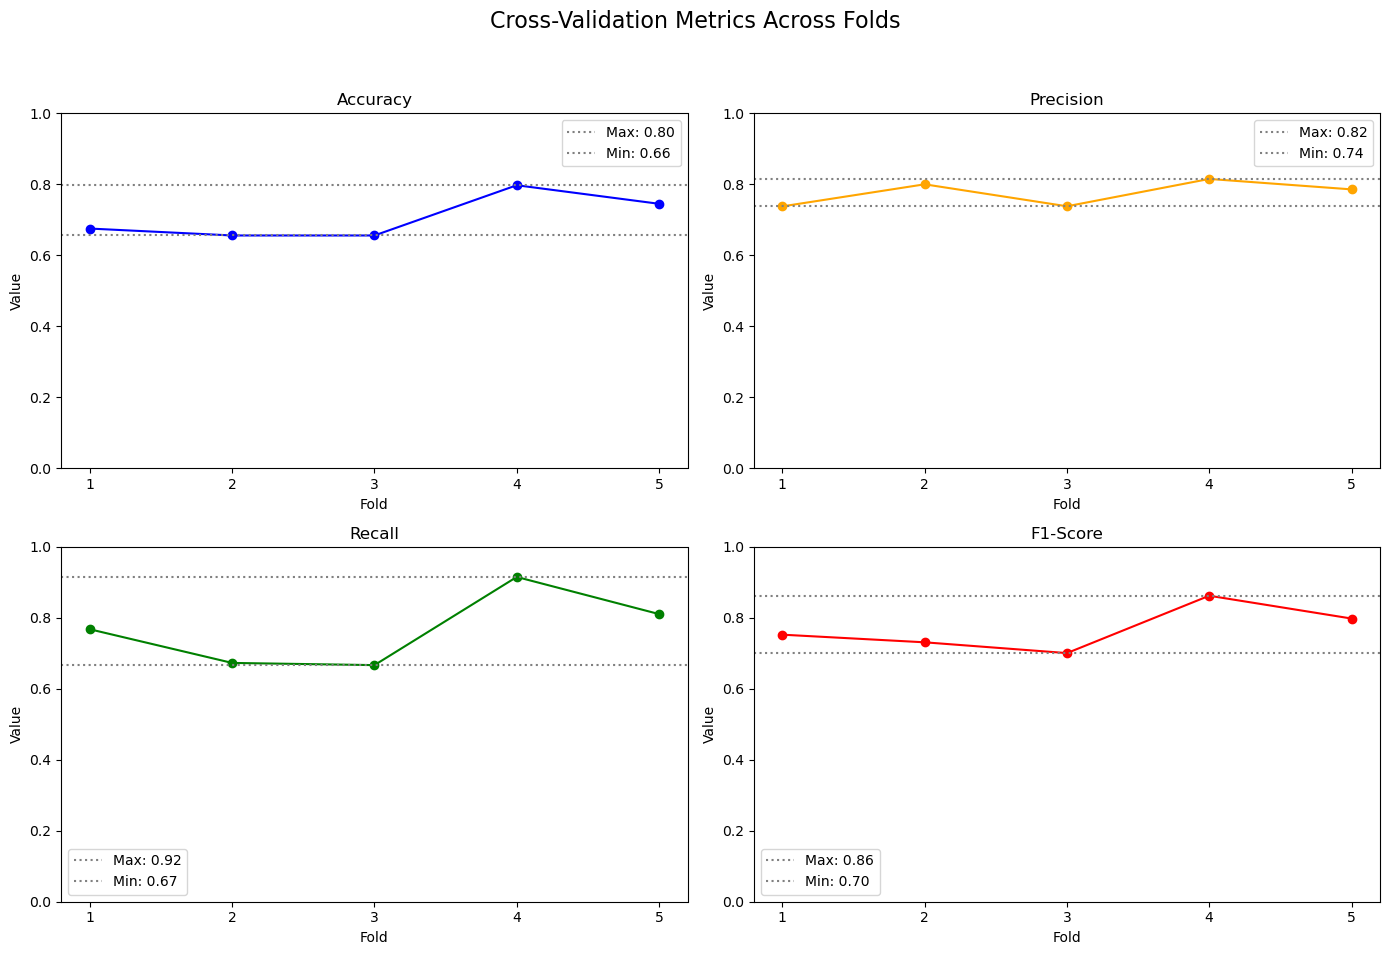

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

fold_numbers = [1, 2, 3, 4, 5]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'orange', 'green', 'red']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    max_val = max(results_df[metric])
    min_val = min(results_df[metric])
    
    ax[row, col].plot(results_df['Fold'], results_df[metric], marker='o', color=colors[i])
    ax[row, col].axhline(y=max_val, color='gray', linestyle='dotted', label=f'Max: {max_val:.2f}')
    ax[row, col].axhline(y=min_val, color='gray', linestyle='dotted', label=f'Min: {min_val:.2f}')
    ax[row, col].set_title(metric)
    ax[row, col].set_xlabel('Fold')
    ax[row, col].set_ylabel('Value')
    ax[row, col].set_xticks(fold_numbers)
    ax[row, col].set_ylim([0, 1])
    ax[row, col].legend()

plt.suptitle('Cross-Validation Metrics Across Folds', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [60]:
learning_rates = [0.0001, 0.001, 0.01]
epochs = [1000, 3000, 5000]

results = []

for lr in learning_rates:
    for epoch in epochs:
        perceptron = RosenblattPerceptron(learning_rate=lr, max_iter=epoch)
        
        perceptron.fit(X_train, y_train)
        
        y_pred = perceptron.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({
            'Learning Rate': lr,
            'Epochs': epoch,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

results_df = pd.DataFrame(results)

results_df


,Learning Rate,Epochs,Accuracy,Precision,Recall,F1-Score
0,0.0001,1000,0.759740,0.762712,0.909091,0.829493
1,0.0001,3000,0.766234,0.756098,0.939394,0.837838
2,0.0001,5000,0.798701,0.861702,0.818182,0.839378
3,0.0010,1000,0.759740,0.762712,0.909091,0.829493
4,0.0010,3000,0.766234,0.756098,0.939394,0.837838
5,0.0010,5000,0.798701,0.861702,0.818182,0.839378
6,0.0100,1000,0.759740,0.762712,0.909091,0.829493
7,0.0100,3000,0.766234,0.756098,0.939394,0.837838
8,0.0100,5000,0.798701,0.861702,0.818182,0.839378


# Plot the graphs

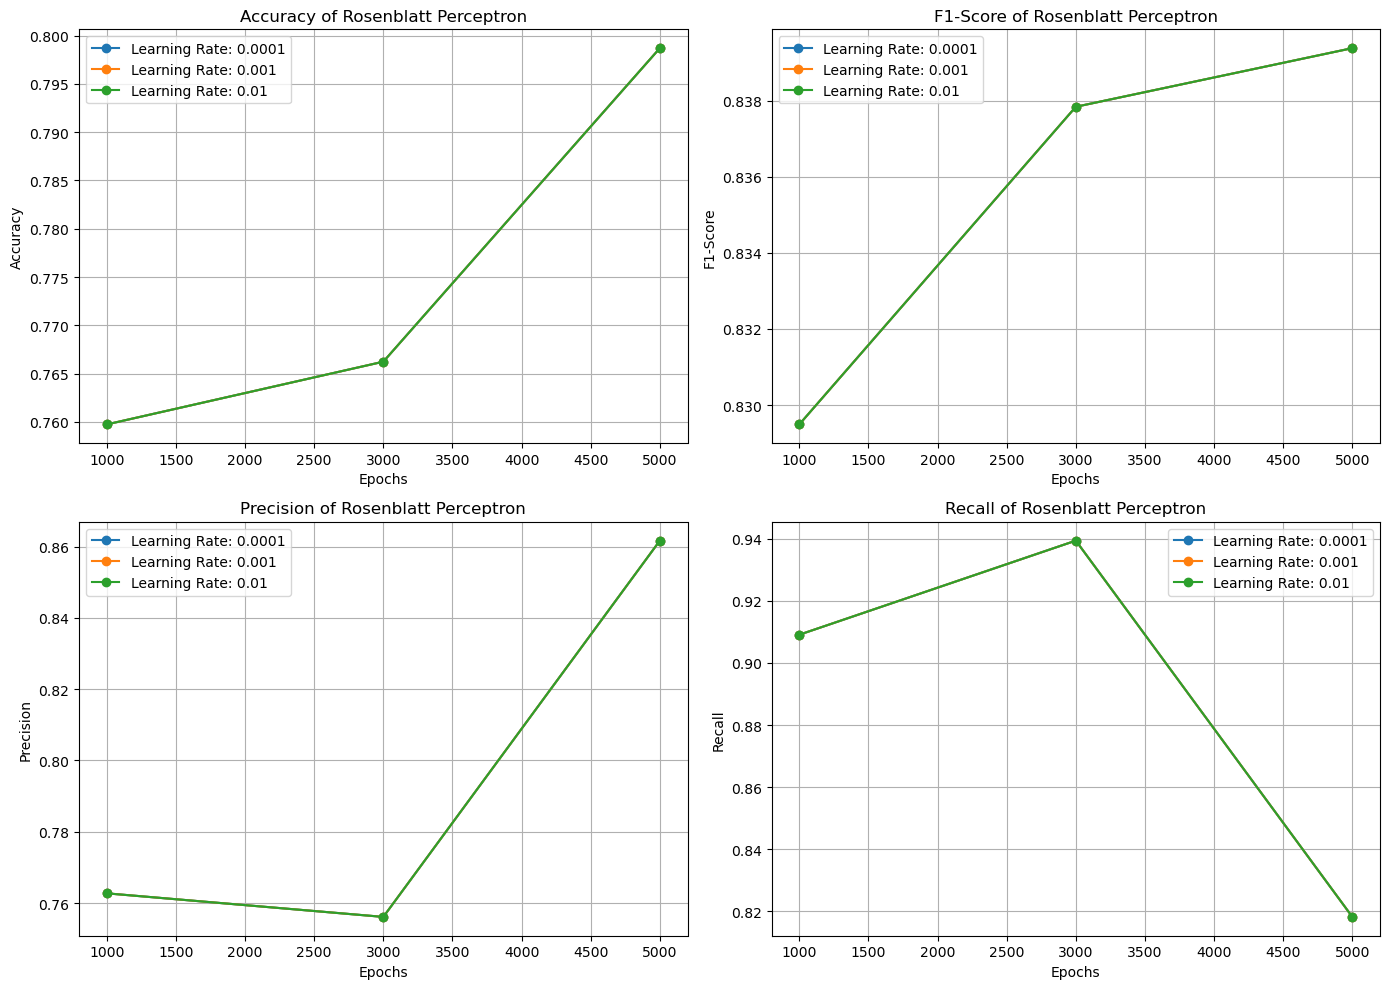

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
titles = ['Accuracy of Rosenblatt Perceptron', 'F1-Score of Rosenblatt Perceptron', 
          'Precision of Rosenblatt Perceptron', 'Recall of Rosenblatt Perceptron']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    
    for lr in learning_rates:
        subset = results_df[results_df['Learning Rate'] == lr]
        ax[row, col].plot(subset['Epochs'], subset[metric], marker='o', label=f'Learning Rate: {lr}')
        
    ax[row, col].set_xlabel('Epochs')
    ax[row, col].set_ylabel(metric)
    ax[row, col].set_title(titles[i])
    ax[row, col].legend()
    ax[row, col].grid(True)

plt.tight_layout()
plt.show()